# Generación de Imágenes de Patrones de Difracción mediante una GAN Condicional

Comenzamos con la instalación de Tensorflow

In [ ]:
!pip install tensorflow

Dercargamos los archivos y los cargamos directamente del Drive

In [ ]:
from google.colab import drive
import zipfile
import os

# Vinculamos Google Drive
drive.mount('/content/drive')

# Ruta del archivo comprimido
zip_path = "/content/drive/MyDrive/Facultad de Ciencias/Colab Notebooks/Ciencia de Datos/Diplomado_IA/Proyecto_Final/Patrones de Difracción/diffranet.zip"
extract_path = "/content/difraccion_data"

# Descomprimimos
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Imágenes descomprimidas


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob

# Tamaño deseado (ajustado para DCGAN)
img_size = (64, 64)

def cargar_imagenes(ruta):
    imagenes = []
    for img_path in glob.glob(os.path.join(ruta, "**/*.png"), recursive=True):
        img = load_img(img_path, color_mode="grayscale", target_size=img_size)
        img_array = img_to_array(img)
        img_array = (img_array - 127.5) / 127.5  # Normalizamos [-1, 1]
        imagenes.append(img_array)
    return np.array(imagenes)

# Cargamos las imágenes
imagenes = cargar_imagenes(extract_path)
print("Total de imágenes cargadas:", imagenes.shape[0])


Total de imágenes cargadas: 25914


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Dimensión del vector de entrada al generador
latent_dim = 100

# Generador
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminador
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                      input_shape=[64, 64, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [ ]:
import time

generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Optimizadores
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Hiperparámetros
BATCH_SIZE = 512
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Generamos los datos de entrenamiento con ayuda de Tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices(imagenes).shuffle(100000).batch(BATCH_SIZE)

# Fijaremos una semilla
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:03d}.png')
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Epoch {epoch+1} completada en {time.time()-start:.2f} s')

# Entrenamiento
train(train_dataset, EPOCHS)


Epoch 1 completada en 22.81 s
Epoch 2 completada en 13.27 s
Epoch 3 completada en 13.20 s
Epoch 4 completada en 13.20 s
Epoch 5 completada en 13.20 s
Epoch 6 completada en 13.51 s
Epoch 7 completada en 13.25 s
Epoch 8 completada en 13.24 s
Epoch 9 completada en 13.23 s
Epoch 10 completada en 13.21 s
Epoch 11 completada en 13.22 s
Epoch 12 completada en 13.22 s
Epoch 13 completada en 13.21 s
Epoch 14 completada en 13.23 s
Epoch 15 completada en 13.58 s
Epoch 16 completada en 13.21 s
Epoch 17 completada en 13.21 s
Epoch 18 completada en 13.24 s
Epoch 19 completada en 13.26 s
Epoch 20 completada en 13.24 s
Epoch 21 completada en 13.27 s
Epoch 22 completada en 13.24 s
Epoch 23 completada en 13.22 s
Epoch 24 completada en 13.24 s
Epoch 25 completada en 13.22 s
Epoch 26 completada en 13.69 s
Epoch 27 completada en 13.25 s
Epoch 28 completada en 13.24 s
Epoch 29 completada en 13.23 s
Epoch 30 completada en 13.24 s
Epoch 31 completada en 13.19 s
Epoch 32 completada en 13.21 s
Epoch 33 completa

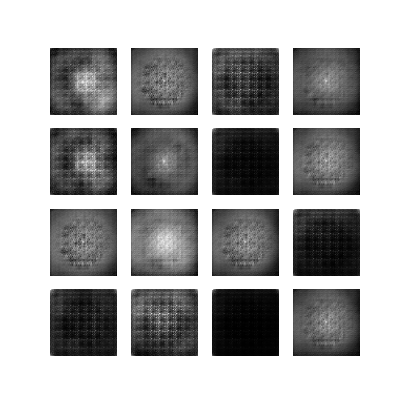

In [ ]:
from IPython.display import Image, display

# Mostramos una de las imágenes generadas
display(Image(filename="image_at_epoch_100.png"))